In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"swapnilverma007","key":"227134f60db029bb65e270ddb8867edb"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
100% 1.68G/1.68G [01:32<00:00, 23.4MB/s]
100% 1.68G/1.68G [01:32<00:00, 19.6MB/s]


In [ ]:
!unzip deepfake-and-real-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

In [ ]:
import tensorflow as tf
import pathlib
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split

In [ ]:
def process_path(file_path):
    label=tf.strings.split(file_path,'/')[-2]=='Real'
    label = tf.cast(label, tf.float32)
    img=tf.io.read_file(file_path)
    img=tf.image.decode_jpeg(img,channels=3)
    img = tf.image.resize(img, [128, 128])
    img /= 255.0

    return img, label

In [ ]:
def get_dataset(directory, shuffle=True):
    list_ds = tf.data.Dataset.list_files(str(directory / '*/*'), shuffle=False)
    if shuffle:
        list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)
    return list_ds.map(process_path).batch(32)

In [ ]:
train_ds = get_dataset(pathlib.Path('/content/Dataset/Train'), shuffle=True)
validation_ds = get_dataset(pathlib.Path('/content/Dataset/Validation'), shuffle=False)
test_ds = get_dataset(pathlib.Path('/content/Dataset/Test'), shuffle=False)

In [ ]:
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

train_ds = train_ds.map(augment_data)

In [ ]:
def print_batch(ds):
    for images, labels in ds.take(1):
        print("Images shape: ", images.shape)
        print("Labels: ", labels.numpy())

print("Train dataset:")
print_batch(train_ds)

print("\nValidation dataset:")
print_batch(validation_ds)

print("\nTest dataset:")
print_batch(test_ds)

Train dataset:
Images shape:  (32, 128, 128, 3)
Labels:  [1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 1.]

Validation dataset:
Images shape:  (32, 128, 128, 3)
Labels:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]

Test dataset:
Images shape:  (32, 128, 128, 3)
Labels:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
4376/4376 [==============================] - 254s 56ms/step - loss: 0.3675 - accuracy: 0.8166 - val_loss: 0.3241 - val_accuracy: 0.8538
Epoch 2/10
4376/4376 [==============================] - 219s 50ms/step - loss: 0.1802 - accuracy: 0.9257 - val_loss: 0.2591 - val_accuracy: 0.8882
Epoch 3/10
4376/4376 [==============================] - 243s 56ms/step - loss: 0.1484 - accuracy: 0.9401 - val_loss: 0.2523 - val_accuracy: 0.8906
Epoch 4/10
4376/4376 [==============================] - 225s 51ms/step - loss: 0.1317 - accuracy: 0.9471 - val_loss: 0.2035 - val_accuracy: 0.9137
Epoch 5/10
4376/4376 [==============================] - 205s 47ms/step - loss: 0.1200 - accuracy: 0.9520 - val_loss: 0.2488 - val_accuracy: 0.8937
Epoch 6/10
4376/4376 [==============================] - 209s 48ms/step - loss: 0.1119 - accuracy: 0.9555 - val_loss: 0.2560 - val_accuracy: 0.8940
Epoch 7/10
4376/4376 [==============================] - 233s 53ms/step - loss: 0.1066 - accuracy: 0.9574 - val_loss: 0

In [ ]:
model.save('my_model')

In [ ]:
!zip -r my_model.zip my_model
files.download('my_model.zip')

  adding: my_model/ (stored 0%)
  adding: my_model/assets/ (stored 0%)
  adding: my_model/fingerprint.pb (stored 0%)
  adding: my_model/variables/ (stored 0%)
  adding: my_model/variables/variables.data-00000-of-00001 (deflated 36%)
  adding: my_model/variables/variables.index (deflated 65%)
  adding: my_model/saved_model.pb (deflated 88%)
  adding: my_model/keras_metadata.pb (deflated 93%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

341/341 - 6s - loss: 0.2459 - accuracy: 0.9022 - 6s/epoch - 17ms/step
Test loss: 0.24586516618728638
Test accuracy: 0.9021549820899963


In [ ]:
!wget https://theshaderoom.com/wp-content/uploads/2022/05/Elon-Musk-scaled-e1652223706691.jpg

--2024-06-06 19:38:00--  https://theshaderoom.com/wp-content/uploads/2022/05/Elon-Musk-scaled-e1652223706691.jpg
Resolving theshaderoom.com (theshaderoom.com)... 192.0.66.162, 2a04:fa87:fffd::c000:426d
Connecting to theshaderoom.com (theshaderoom.com)|192.0.66.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117381 (115K) [image/jpeg]
Saving to: ‘Elon-Musk-scaled-e1652223706691.jpg’

Elon-Musk-scaled-e1 100%[===================>] 114.63K  --.-KB/s    in 0.003s  

2024-06-06 19:38:00 (39.7 MB/s) - ‘Elon-Musk-scaled-e1652223706691.jpg’ saved [117381/117381]



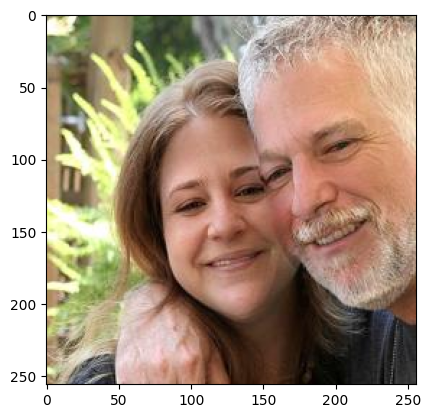

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('fake_4.jpg')

plt.imshow(img)
plt.show()

In [ ]:
from PIL import Image
import numpy as np

img = Image.open('fake_4.jpg')

img = img.resize((128, 128))

img_array = np.array(img) / 255.0

img_array = np.expand_dims(img_array, axis=0)

In [ ]:
predictions = model.predict(img_array)

threshold = 0.5

if predictions < threshold:
    print("The image is a deepfake.")
else:
    print("The image is real.")

print(predictions)

1/1 [==============================] - 0s 19ms/step
The image is a deepfake.
[[0.16207425]]
